# Download and Unzip Function

To see the download and unzipping progress

In [1]:
!pip install lemma-dev-utils
!pip install pyspark
!pip install shapely==1.8.5 -U
!pip install rtree
!pip install scikit-mobility

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


# Downloading the Dataset

In [2]:
with open('dataset_url.txt', 'r') as url_file:
    url = url_file.read()

In [3]:
from lemma_dev_utils import download_unzip, download 
import os

path = 'dataset'

download_unzip(path, url)
os.chdir(path)

Unzipping train_labels.csv: 100%|##########| 30752769/30752769 [00:00<00:00, 81410546.00it/s]


# Setting up Spark

In [4]:
# constant that sets the fraction of sample to collect when intending to manage data out of spark
SAMPLE_FRAC = 0.01

In [5]:
from lemma_dev_utils import download_unzip, download
import os

import itertools
import numpy as np
import random
import seaborn as sns
import re
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, lit

import math
from math import exp, e
from statistics import mean

from pyspark.sql import SparkSession

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report as cr
from collections import Counter

from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import DoubleType
from pyspark.ml.functions import vector_to_array

import pyspark.sql.functions as f
from pyspark.sql.functions import variance, col, lit, when, udf

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.clustering import BisectingKMeans

from pyspark.ml.feature import StringIndexer, VectorIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.feature import VarianceThresholdSelector
from pyspark.ml.feature import PCA

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC, OneVsRest

from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [6]:
def compute_metrics(labelCol="target", predictionCol="prediction", metricLabel = 1):
    """
    Returning a dictionary with most relevant evaluation metrics
    """

    class_report = dict()
    for metric in ['f1', 'accuracy', 'recallByLabel', 'precisionByLabel']:
    # Select (prediction, true label) and compute test error
        evaluator = MulticlassClassificationEvaluator(labelCol=labelCol,
                                                        predictionCol=predictionCol,
                                                        metricName=metric,
                                                        metricLabel = metricLabel)

        class_report[metric] = evaluator.evaluate(predictions)
    return class_report 

In [7]:
def get_ytest_ypred(target_prediction = ['target', 'prediction']):
    """
    Returning y_test and y_pred lists
    """
    target, prediction = target_prediction
    
    lists = predictions.select(target_prediction)
    lists = lists.sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42).collect()
    y_test = [row[target] for row in lists]
    y_pred = [row[prediction] for row in lists]
    return y_test, y_pred

In [8]:
def plot_conf_matrix(palette, title = '', target_prediction = ['prediction', 'target']):
    """ 
    Plots Confusion Matrix.
    From documentation: confusionMatrix() take as parameter an RDD of (prediction, label) pairs
    """

    pred_and_labels = predictions.select(target_prediction)
    metrics = MulticlassMetrics(pred_and_labels.rdd.map(tuple))
    confusion_matrix_to_plot = metrics.confusionMatrix().toArray()
    plt.figure(figsize=(8,5))
    sns.heatmap(confusion_matrix_to_plot, fmt='g', annot=True, annot_kws={"size": 20}, 
                xticklabels = ['F', 'T'], yticklabels = ['F', 'T'], cmap=palette)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title, fontsize = 20)
    plt.show()

In [9]:
def plot_roc_curve(labelCol = "target"):
    """ Take the data in rdd format for plotting roc curve """
    
    sampled = predictions.select(labelCol, vector_to_array("probability")[1]).sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42)
    sampled_out = np.array(sampled.rdd.map(tuple).collect())
    y_true = sampled_out[:,0]
    y_score = sampled_out[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.title('ROC Curve', fontsize = 20)
    plt.show()

In [10]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
        
sc = spark.sparkContext

# Loading the Training Set

In [11]:
raw_data = sc.textFile("train_data.csv")
raw_labels = sc.textFile("train_labels.csv")

# Preprocessing



## Managing Numeric and NaN values

In [12]:
def isnumeric_val(val):
    non_negative = val.replace("-", "", 1)
    non_decimal = non_negative.replace(".", "", 1)
    non_scientific = non_decimal.replace("e-", "", 1).replace("e", "", 1)
    isitnumeric = non_scientific.isdigit()
    return isitnumeric

def clean_split_csv(row):
    # Split Row
    split_row = row.split(',')
    new_row = list()

    for val in split_row:
        # Fill NaN
        val = val if val != '' else '0.0'
        # Rounding numbers
        val_toadd = math.floor(float(val)*1000)/1000 if isnumeric_val(val) else val
        new_row.append(val_toadd)

    return tuple(new_row)

## Getting features, labels and the header

In [13]:
# cleaning the training data
clean_data = raw_data.map(lambda row: clean_split_csv(row))
header_features = clean_data.take(1)[0]
features = clean_data.filter(lambda x: x != header_features)

# cleaning the training labels
clean_labels = raw_labels.map(lambda row: clean_split_csv(row))
header_labels = clean_labels.take(1)[0]
labels = clean_labels.filter(lambda x: x != header_labels)

print(f"Features count: {len(features.take(1)[0])}")

Features count: 190


## Sampling the dataset

In [14]:
print(f"Number of partition used: {features.getNumPartitions()}")

Number of partition used: 489


## From RDD to DF

In [15]:
%%time
df = features.toDF(header_features)
df_schema = df.schema

CPU times: user 33.4 ms, sys: 8.33 ms, total: 41.7 ms
Wall time: 3.29 s


## Checking column names

In [16]:
df_columns = df.columns
len(header_features) == len(df_columns)

True

In [17]:
header_features == tuple(df_columns)

True

In [18]:
header_features[:5], df_columns[:5]

(('customer_ID', 'S_2', 'P_2', 'D_39', 'B_1'),
 ['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1'])

## Dataset Shape and Schema

In [19]:
df.show(5)

+--------------------+----------+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+----+-----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+----+-----+-----+----+-----+-----+-----+-----+-----+---+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [20]:
schema = {col.name : str(col.dataType) for col in df.schema}
print("Dataset Schema: \n", *[f"{x}\n" for x in schema.items() if x[1] != 'DoubleType()'])

Dataset Schema: 
 ('customer_ID', 'StringType()')
 ('S_2', 'StringType()')
 ('D_63', 'StringType()')
 ('D_64', 'StringType()')



In [21]:
%%time
n_rows = df.count()
n_columns = len(df_columns)
print(f"n° o Rows: {n_rows}")
print(f"n° o Columns: {n_columns}")

n° o Rows: 5531451
n° o Columns: 190
CPU times: user 3.46 s, sys: 383 ms, total: 3.84 s
Wall time: 11min 15s


## Categorical dimensions handling

In [22]:
def plot_donut(name, counter):
    """ Plotting a Donut Plot """
    fig, ax = plt.subplots(figsize=(12, 5), subplot_kw=dict(aspect="equal"))

    wedges, texts = ax.pie(counter.values(), wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(list(counter.keys())[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title(f"{name} Distribution")

    plt.show()

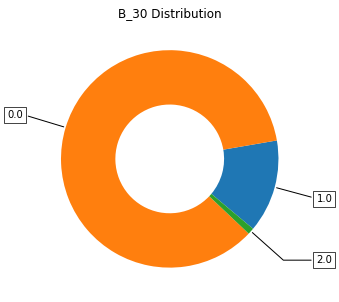

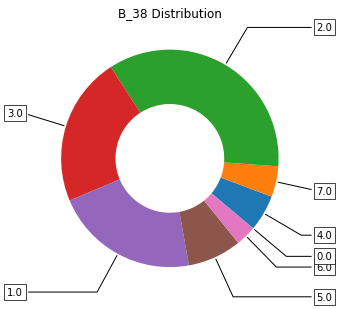

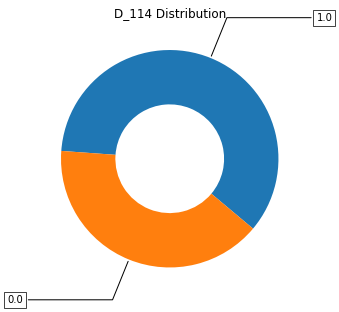

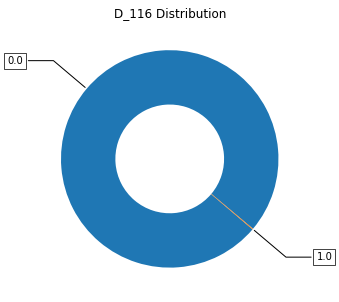

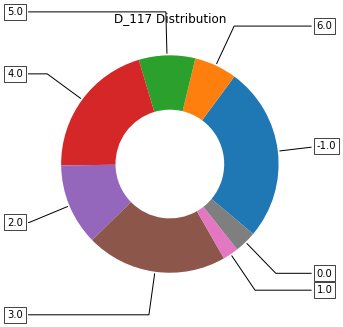

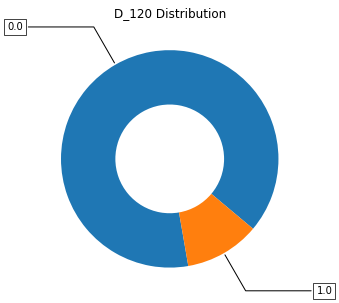

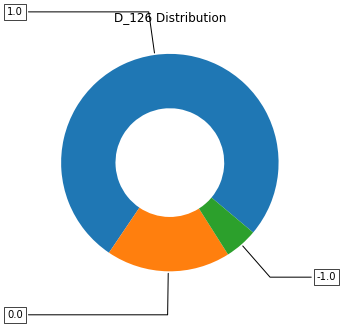

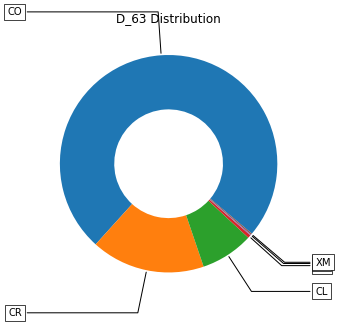

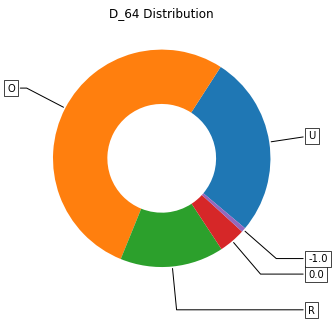

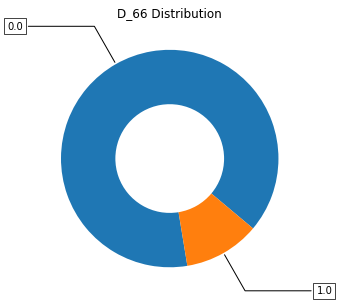

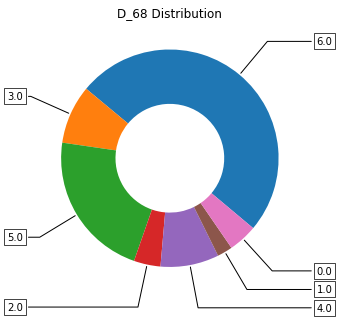

In [23]:
# input from American Express challenge
categorical_variables = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

get_df_categories = df.select(categorical_variables).sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42).collect()

for var in categorical_variables:
    var_collect = [x[var] for x in get_df_categories]
    counter = Counter(var_collect)
    plot_donut(var, counter)

In [24]:
df.printSchema()

root
 |-- customer_ID: string (nullable = true)
 |-- S_2: string (nullable = true)
 |-- P_2: double (nullable = true)
 |-- D_39: double (nullable = true)
 |-- B_1: double (nullable = true)
 |-- B_2: double (nullable = true)
 |-- R_1: double (nullable = true)
 |-- S_3: double (nullable = true)
 |-- D_41: double (nullable = true)
 |-- B_3: double (nullable = true)
 |-- D_42: double (nullable = true)
 |-- D_43: double (nullable = true)
 |-- D_44: double (nullable = true)
 |-- B_4: double (nullable = true)
 |-- D_45: double (nullable = true)
 |-- B_5: double (nullable = true)
 |-- R_2: double (nullable = true)
 |-- D_46: double (nullable = true)
 |-- D_47: double (nullable = true)
 |-- D_48: double (nullable = true)
 |-- D_49: double (nullable = true)
 |-- B_6: double (nullable = true)
 |-- B_7: double (nullable = true)
 |-- B_8: double (nullable = true)
 |-- D_50: double (nullable = true)
 |-- D_51: double (nullable = true)
 |-- B_9: double (nullable = true)
 |-- R_3: double (nullable = t

In [25]:
categorical_df = df.select(categorical_variables)
categorical_df.show(5)

+----+----+-----+-----+-----+-----+-----+----+----+----+----+
|B_30|B_38|D_114|D_116|D_117|D_120|D_126|D_63|D_64|D_66|D_68|
+----+----+-----+-----+-----+-----+-----+----+----+----+----+
| 0.0| 2.0|  1.0|  0.0|  4.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
| 0.0| 2.0|  1.0|  0.0|  4.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
| 0.0| 2.0|  1.0|  0.0|  4.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
| 0.0| 2.0|  1.0|  0.0|  4.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
| 0.0| 2.0|  1.0|  0.0|  4.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
+----+----+-----+-----+-----+-----+-----+----+----+----+----+
only showing top 5 rows



In [26]:
categorical_df.describe().show()

+-------+-------------------+-----------------+------------------+--------------------+------------------+-------------------+------------------+-------+--------------------+-------------------+------------------+
|summary|               B_30|             B_38|             D_114|               D_116|             D_117|              D_120|             D_126|   D_63|                D_64|               D_66|              D_68|
+-------+-------------------+-----------------+------------------+--------------------+------------------+-------------------+------------------+-------+--------------------+-------------------+------------------+
|  count|            5531451|          5531451|           5531451|             5531451|           5531451|            5531451|           5531451|5531451|             5531451|            5531451|           5531451|
|   mean|0.15793125528907334|2.715714195063827|0.5995674552662583|0.001197877374309...|2.2449684540277044|0.11299241374460336|0.7234116328608895

D_117 and D_126 may be a problem as they were known values but we changed the nan values to 0, they have negative values I'll make them 0.5 to adjust to a category semantically closer to the original one

## Fixing the negative values appearing in the categories

In [28]:
for i in ['D_117', 'D_126', 'D_64']:
    df = df.withColumn(i, when((col(i) == -1.0), 0.5).otherwise(col(i)))

## Casting string-type categories to numeric
As per the request of Spark

In [29]:
new_categorical_variables = [f'{col}_numeric' for col in categorical_variables]
indexer = StringIndexer(inputCols=categorical_variables, outputCols=new_categorical_variables).fit(df)
df = indexer.transform(df)

In [30]:
categorical_df = df.select(categorical_variables+new_categorical_variables)

In [31]:
# dropping old columns from dataframe
df = df.drop(*categorical_variables)

## One hot encoding Categorical variables

In [32]:
output_col_names = [f'{col}_enc' for col in categorical_variables]
encoder = OneHotEncoder(inputCols = new_categorical_variables, 
                        outputCols = output_col_names)

model = encoder.fit(df)
df = model.transform(df)

# dropping the numeric columns from df
df = df.drop(*new_categorical_variables)

df.select(output_col_names).show(5)

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|     B_30_enc|     B_38_enc|    D_114_enc|    D_116_enc|    D_117_enc|    D_120_enc|    D_126_enc|     D_63_enc|     D_64_enc|     D_66_enc|     D_68_enc|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|(2,[0],[1.0])|(7,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[2],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[1],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[2],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[1],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[2],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[1],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[2],

In [33]:
# renaming back columns to original names
for encoded_name, original_name in zip(output_col_names, categorical_variables):
    df = df.withColumnRenamed(encoded_name, original_name)

## Getting the Labels to Join them

In [34]:
label_df = labels.toDF()
label_cols = label_df.columns
for label_wrong_col, label_correct_col in zip(label_cols, header_labels):
    label_df = label_df.withColumnRenamed(label_wrong_col, label_correct_col)
label_df.show(5)

+--------------------+------+
|         customer_ID|target|
+--------------------+------+
|0000099d6bd597052...|   0.0|
|00000fd6641609c6e...|   0.0|
|00001b22f846c82c5...|   0.0|
|000041bdba6ecadd8...|   0.0|
|00007889e4fcd2614...|   0.0|
+--------------------+------+
only showing top 5 rows



In [35]:
df = df.join(label_df, ['customer_ID'])

In [36]:
columns_final = ['customer_ID', 'S_2', 'target']
feature_to_assemble = [col for col in header_features if col not in columns_final]

vecAssembler = VectorAssembler(inputCols=feature_to_assemble, 
                               outputCol="features")

assembled_df = vecAssembler.transform(df).select(columns_final+['features'])

In [37]:
assembled_df.show(5)

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|            features|
+--------------------+----------+------+--------------------+
|000678921d09c5503...|2017-03-04|   0.0|[0.953,0.005,0.00...|
|000678921d09c5503...|2017-04-04|   0.0|[0.956,0.006,0.00...|
|000678921d09c5503...|2017-05-04|   0.0|[0.95,0.0,0.005,0...|
|000678921d09c5503...|2017-06-03|   0.0|[0.955,0.005,0.00...|
|000678921d09c5503...|2017-07-04|   0.0|[0.963,0.007,0.00...|
+--------------------+----------+------+--------------------+
only showing top 5 rows



In [38]:
distinct_values_per_category = {k : vector.__len__() for k, vector in df.select(categorical_variables).take(1)[0].asDict().items()}

In [39]:
distinct_values_per_category

{'B_30': 2,
 'B_38': 7,
 'D_114': 1,
 'D_116': 1,
 'D_117': 7,
 'D_120': 1,
 'D_126': 2,
 'D_63': 5,
 'D_64': 4,
 'D_66': 1,
 'D_68': 6}

In [40]:
# building the correct feature list (bc one hot encoding depacking was needed)

correct_col_list = list()

for col in feature_to_assemble:
    col_repeat = distinct_values_per_category.get(col, 1)
    for n in range(1, col_repeat+1):
        correct_col_list.append(col+'_'+str(n) if n > 1 else col)

In [41]:
# sampling the dataset before plotting
sample_assembled = assembled_df.sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42).select(['target', 'features'])

collected_assembled = sample_assembled.toPandas()
labels_collected = collected_assembled['target'] # extract target variable

# making a densevector if it is sparse and then expanding the vector into multiple columns
collected_assembled = collected_assembled.apply(lambda x: DenseVector(x["features"]), result_type="expand", axis=1)
collected_assembled.columns = correct_col_list
collected_assembled['target'] = labels_collected

In [42]:
collected_assembled.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0.486,0.034,0.088,0.036,0.504,0.358,0.002,0.123,0.138,0.000,...,0.0,0.0,0.008,0.005,0.006,0.000,0.008,0.008,0.009,1.0
1,0.594,0.382,0.021,0.039,0.006,0.038,0.004,0.516,0.000,0.180,...,0.0,0.0,0.007,0.007,0.006,0.000,0.009,0.004,0.002,0.0
2,0.615,0.002,0.055,1.004,0.002,0.562,0.006,0.007,0.000,0.293,...,0.0,0.0,1.001,0.004,0.872,0.195,1.006,0.003,0.186,0.0
3,0.328,0.036,0.022,0.289,0.508,0.544,0.005,0.064,0.026,0.000,...,0.0,0.0,0.001,0.001,0.005,0.000,0.002,0.003,0.006,1.0
4,0.876,0.006,0.010,0.819,0.003,0.148,0.008,0.024,0.000,0.000,...,0.0,0.0,0.005,0.009,0.004,0.000,0.005,0.000,0.001,0.0


In [43]:
d_cols = [col for col in feature_to_assemble+['target'] if col[0].lower() == "d" or col == 'target']

In [44]:
collected_assembled[d_cols].head()

,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0.034,0.002,0.138,0.000,0.252,0.010,0.467,0.028,0.664,0.000,...,0.0,0.0,0.008,0.005,0.006,0.000,0.008,0.008,0.009,1.0
1,0.382,0.004,0.000,0.180,0.254,0.482,0.604,0.335,0.438,0.346,...,0.0,0.0,0.007,0.007,0.006,0.000,0.009,0.004,0.002,0.0
2,0.002,0.006,0.000,0.293,0.130,0.039,0.502,0.101,0.403,0.000,...,0.0,0.0,1.001,0.004,0.872,0.195,1.006,0.003,0.186,0.0
3,0.036,0.005,0.026,0.000,0.009,0.021,0.516,0.040,0.299,0.000,...,0.0,0.0,0.001,0.001,0.005,0.000,0.002,0.003,0.006,1.0
4,0.006,0.008,0.000,0.000,0.006,0.266,0.438,0.420,0.244,0.000,...,0.0,0.0,0.005,0.009,0.004,0.000,0.005,0.000,0.001,0.0


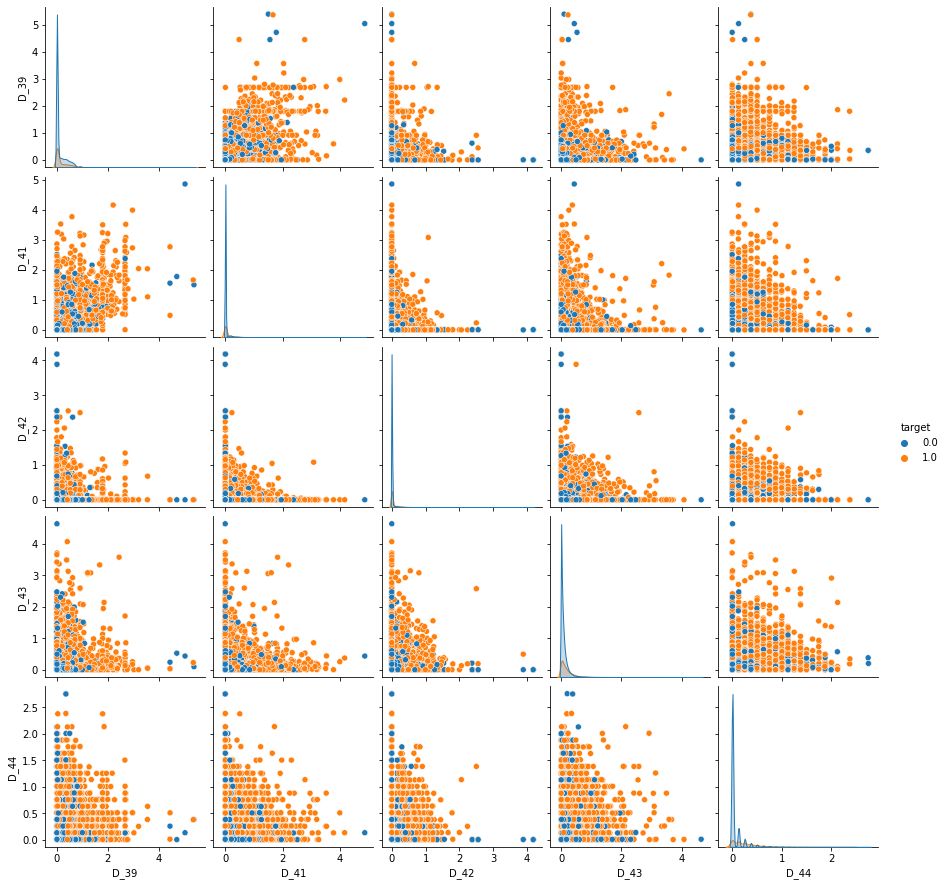

In [45]:
sns.pairplot(data = collected_assembled[d_cols[:5]+['target']], hue = 'target')
plt.show()

# Some visualizations of relashionships between variables

From a visualization point of view, we focused on relationship between some different type of variables in order to have a more clear perspective of how these variables are related between them.

In [46]:
vals = list(collected_assembled['target'].unique())
vals

[1.0, 0.0]

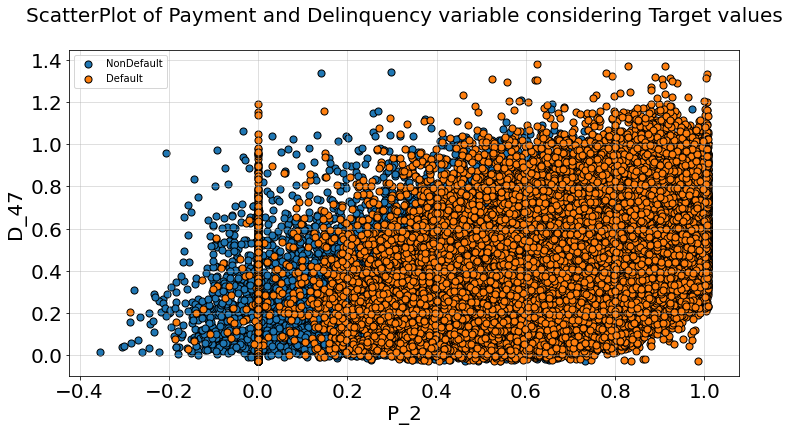

In [47]:
x = 'P_2'
y = 'D_47'

plt.figure(figsize=(12,6))
for val in vals:
    df_val = collected_assembled[collected_assembled['target']==val]
    plt.scatter(df_val[x], df_val[y], s=50, edgecolor='black', label=val)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(x, fontsize=20)
plt.ylabel(y, fontsize=20)

plt.grid(alpha=0.5)
plt.legend(['NonDefault', 'Default'],  loc='best')
plt.title('ScatterPlot of Payment and Delinquency variable considering Target values\n', fontsize=20)
plt.show()

From this scatterplot, we can suppose that, with a lower value of P_2 (it can represent the payment amount of a customer), we have a dense cluster point of NonDefault customers related to a higher value of delinquency. In other words, if a customer is represented by an higher value of deliquency it doesn't mean that this client will default but instead, in contrast we see that customers with lower values of deliquency are those that are more inclined to Default.

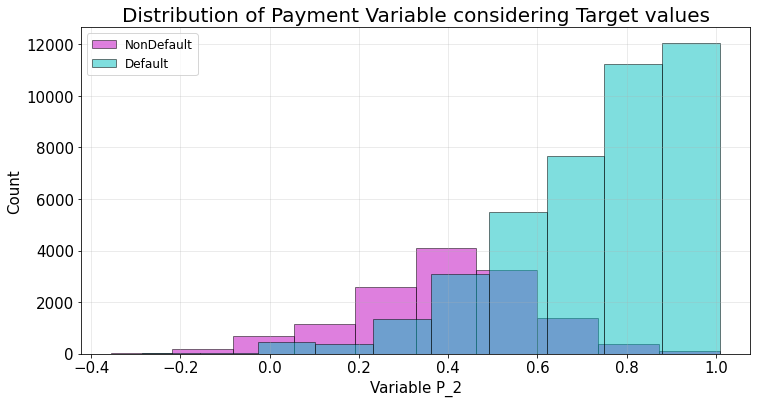

In [48]:
colors = ['m', 'c']
plt.figure(figsize=(12,6))
for i, val in enumerate(vals):
    plt.hist( collected_assembled[ collected_assembled['target']==val ]['P_2'], color= colors[i],
             edgecolor='black', label=val, alpha=0.5)
    
plt.legend(['NonDefault','Default'],loc='best', fontsize=12)
plt.xticks(fontsize=15)
plt.xlabel('Variable P_2', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of Payment Variable considering Target values', fontsize=20)
plt.grid(alpha=0.3)
plt.show()

Here, considering always the Payment Variable P_2 distribution, we confirm what it is said before, i.e. we have more probability of encounter persons that will Default with a medium/lower amount of payment in opposite to who tends to NonDefault with a higher amount of payment.

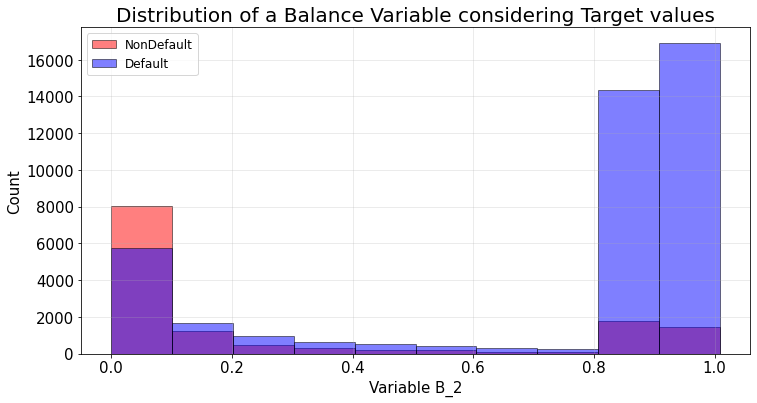

In [49]:
colors = ['r', 'b']
plt.figure(figsize=(12,6))
for i, val in enumerate(vals):
    plt.hist( collected_assembled[ collected_assembled['target']==val ]['B_2'], color= colors[i],
             edgecolor='black', label=val, alpha=0.5)
    
plt.legend(['NonDefault','Default'],loc='best', fontsize=12)
plt.xticks(fontsize=15)
plt.xlabel('Variable B_2', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of a Balance Variable considering Target values', fontsize=20)
plt.grid(alpha=0.3)
plt.show()

In this case we consider the distribution of a Balance Variable (here B_2) with the related Target values (always default and not default), we observe that customers that have a low Balance tend to Default more in respect to those that have a high Balance.

In [50]:
vals2 = list(collected_assembled['D_63'].unique())
vals2

[1.0, 0.0]

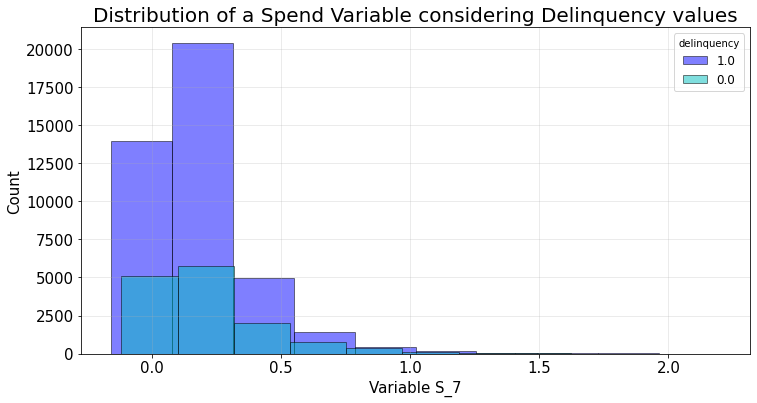

In [51]:
colors = ['b', 'c']
plt.figure(figsize=(12,6))
for i, val in enumerate(vals2):
    plt.hist( collected_assembled[ collected_assembled['D_63']==val ]['S_7'], color= colors[i],
             edgecolor='black', label=val, alpha=0.5)
    
plt.legend(loc='best', fontsize=12,title='delinquency')
plt.xticks(fontsize=15)
plt.xlabel('Variable S_7', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of a Spend Variable considering Delinquency values', fontsize=20)
plt.grid(alpha=0.3)
plt.show()

Here, considering the distribution of the S_7 Spend Variable and taking into account, in this case, the deliquency values taken from variable D_63, we see that we have, with lower values of Spend, more or less the same trend both for delinquency and not delinquency but, in general, there's a majority of people with higher delinquency in that first zone of Spend.

In [52]:
# e.g: D_* = Delinquency variables
#      S_* = Spend variables
#      P_* = Payment variables
#      B_* = Balance variables
#      R_* = Risk variables

In [53]:
# for only non categorical variables, extract a dictionary with "type of variable" : "list of variables"

distinct_vars = {var: list() for var in ["d", "s", "p", "b", "r"]}

for col in sorted(df.columns)[:-2]:
    if col not in categorical_variables + ["S_2"]:
        initial = col[0].lower()
        distinct_vars[initial].append(col)

print(distinct_vars)

{'d': ['D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96'], 's': ['S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9'], 'p': ['P_2', 'P_3', 'P_4'], 'b': ['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15',

# Feature Selections


## Feature Selection Univariate

These will be the features we will use from now on

In [57]:
# ChiSqSelector - Deprecated since version 3.1.0: Thus UnivariateFeatureSelector

selector = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures",
                                     labelCol="target", selectionMode="numTopFeatures")

selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(20)

columns_final.append('selectedFeatures')

fitting = selector.fit(assembled_df)
selected_feat = fitting.selectedFeatures

result = fitting.transform(assembled_df).select(columns_final)

print(f"UnivariateFeatureSelector output with top {selector.getSelectionThreshold()} features selected using f_classif")

UnivariateFeatureSelector output with top 20.0 features selected using f_classif


In [58]:
result.take(1)

[Row(customer_ID='000678921d09c5503d34055ab96b150a972f59a96471b987415c21ba1e86605a', S_2='2017-03-04', target=0.0, selectedFeatures=DenseVector([0.953, 0.005, 0.004, 0.812, 0.002, 0.0, 0.005, 0.008, 0.0, 0.0, 0.001, 0.019, 0.469, 0.008, 0.004, 0.406, 0.544, 0.038, 0.0, 0.248]))]

In [59]:
#selected explicit features
new_header = [col for col in df.columns if col not in columns_final]
sel_feat_expl = [new_header[n] for n in selected_feat]

In [60]:
print('Features Extracted: ')
print(*sel_feat_expl, sep = ', ')

Features Extracted: 
P_2, D_39, B_1, B_2, R_1, S_3, D_41, B_3, D_42, D_43, D_44, B_4, D_45, B_5, R_2, D_46, D_47, D_48, D_49, B_6


## Plotting Original and Selected Features

Here the original features

In [61]:
# getting the distribution of the original type of variables
# e.g: D_* = Delinquency variables
#      S_* = Spend variables
#      P_* = Payment variables
#      B_* = Balance variables
#      R_* = Risk variables

orig_cdist = Counter(re.findall('\w*_', ' '.join(new_header)))

print(orig_cdist)

Counter({'D_': 96, 'B_': 40, 'R_': 28, 'S_': 21, 'P_': 3})


Now the Selected features

In [62]:
selected_cdist = Counter(re.findall('\w*_', ' '.join(sel_feat_expl)))

print(selected_cdist)

Counter({'D_': 10, 'B_': 6, 'R_': 2, 'P_': 1, 'S_': 1})


It seems the most important variables keep the same distribution as the original one

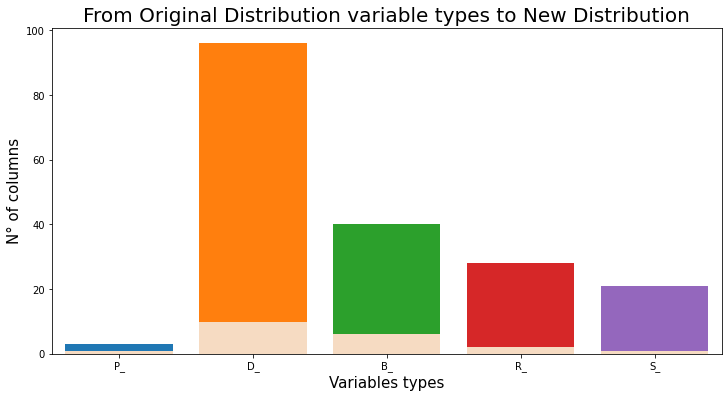

In [63]:
#Plotting Variables Original and New distribution
plt.figure(figsize=(12,6))
plt.ylabel("N° of columns", fontsize=15)
plt.xlabel("Variables types", fontsize=15)
plt.title('From Original Distribution variable types to New Distribution', fontsize=20)
sns.barplot(x=list(orig_cdist.keys()), y=list(orig_cdist.values()), saturation=1)
sns.barplot(x=list(selected_cdist.keys()), y=list(selected_cdist.values()), color='peachpuff')
plt.show()

In [67]:
def plot_feature_importance(importance):

    import pandas as pd
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array([value for var, value in importance])
    feature_names = np.array([var for var,value in importance])

    #Create a DataFrame using a Dictionary
    data = {'feature_names' : feature_names,'feature_importance' : feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Feature Importances of RF',fontsize=18)
    plt.xlabel('Feature Importance',fontsize=12)
    plt.ylabel('Feature Names',fontsize=12)

## Train-Val split

In [70]:
train, validation = result.randomSplit(weights=[0.80,0.20], seed=0)

train = train.sampleBy("target", fractions = {1.0 : .85,
                                              0.0 : .15}, seed= 0)

validation = validation.sampleBy("target", fractions = {1.0 : .85,
                                                        0.0 : .15}, seed= 0)

#Renaming columns due to some incompatibility
train = train.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")
validation = validation.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")

## Random Forest

In [71]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42, numTrees=30)
best_model = rf.fit(train)
predictions = best_model.transform(validation)

In [72]:
rf_feat_imp = best_model.featureImportances
feat_by_imp = sorted(list(zip(rf_feat_imp.indices, rf_feat_imp.toArray())), key = lambda x: -x[1])

correct_feat_by_imp = [(sel_feat_expl[tup[0]], tup[1]) for tup in feat_by_imp]
correct_feat_by_imp

[('P_2', 0.3447232205441742),
 ('D_49', 0.13514646618929654),
 ('B_2', 0.08142965865954155),
 ('B_4', 0.06554880935730041),
 ('D_42', 0.06376220106540258),
 ('B_5', 0.0448703358790975),
 ('D_45', 0.03563315293514128),
 ('D_41', 0.03081663515406318),
 ('S_3', 0.03075168239694693),
 ('R_1', 0.02312898724698014),
 ('D_43', 0.023018707403189367),
 ('D_48', 0.006505988001354494),
 ('R_2', 0.002973649038144389),
 ('D_44', 0.002143496525829137),
 ('B_3', 0.0008686990575990439),
 ('D_47', 0.0003003696936223309),
 ('B_6', 0.0001703399457167439),
 ('D_46', 5.5869986998356685e-05),
 ('B_1', 0.0)]

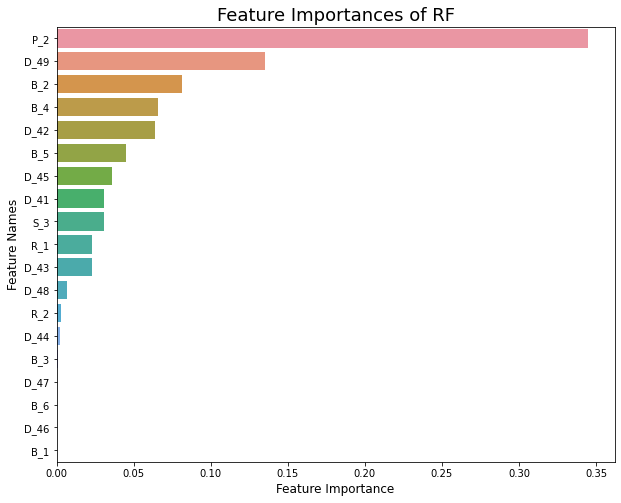

In [73]:
plot_feature_importance(correct_feat_by_imp)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


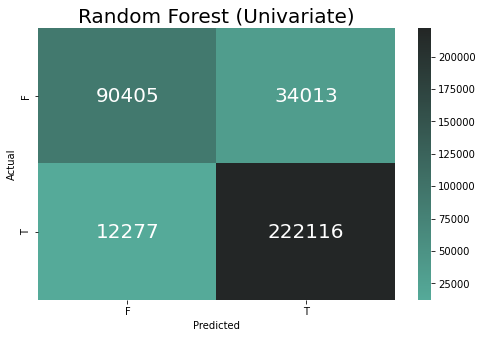

In [74]:
plot_conf_matrix(sns.color_palette("dark:#5A9_r", as_cmap=True), title = 'Random Forest (Univariate)', target_prediction = ['prediction', 'label'])

# Test Set: Predictions and Aggregation by Customer

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
print(sorted(sel_feat_expl))

['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'P_2', 'R_1', 'R_2', 'S_3']


In [84]:
print(sorted(categorical_variables))

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


In [85]:
[x for x in sel_feat_expl if x in categorical_variables]

[]

In [87]:
test_df = spark.read.format("csv") \
          .option("header", True) \
          .schema(df_schema) \
          .load("/content/dataset/test_data.csv")

test_df = test_df.select(['customer_ID', 'S_2'] + sel_feat_expl)
test_df = test_df.fillna(0.0)

# assembling features
vecAssembler = VectorAssembler(inputCols=sel_feat_expl, outputCol="features")
test_df = vecAssembler.transform(test_df).select(['customer_ID', 'S_2']+['features'])

In [88]:
predictions = best_model.transform(test_df)

In [89]:
predictions = predictions.select('customer_ID', 'probability')

In [90]:
predictions = predictions.rdd.map(lambda x: (x.customer_ID, float(x.probability[1]))).toDF(['customer_ID', 'probability'])

In [91]:
output = predictions.groupBy(['customer_ID']).mean('probability')

In [92]:
output_pd = output.toPandas().reset_index(drop = True)

In [93]:
output_pd.columns = ['customer_ID', 'prediction']

In [94]:
output_pd.to_csv('/content/drive/MyDrive/submission_full.csv', index = False)